In [25]:
import random
import datetime
import time
import tqdm
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, mean_squared_log_error, \
    root_mean_squared_error, classification_report

import tensorflow as tf
from tensorflow_docs.vis import embed
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

import imageio

import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk

from IPython import display
from urllib import request

import matplotlib.pyplot as plt


from pathlib import Path

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

Using device: GPU


## Constants

In [3]:
SEED = 476
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [26]:
exp_name  = time.strftime("%m_%d_%Y_%H_%M", time.localtime())
exp_name

'05_10_2025_19_59'

In [5]:
# Pathing
video_dir = "../Videos"
annotations_dir = "../Annotations"
extracted_dir = "../ExtractedFrames"
multi_label_dir = "../MultiLabelFrames"

filtered_path = os.path.join(multi_label_dir, "labels_filtered.csv")
labels_csv_path = os.path.join(multi_label_dir, "labels.csv")

In [6]:
os.makedirs(extracted_dir, exist_ok=True)
os.makedirs(multi_label_dir, exist_ok=True)

# Osztályok listája "timestamp" kivételével
with open(os.path.join(annotations_dir, 
                       os.listdir(annotations_dir)[0]), 'r') as f:
    header = f.readline().strip().split(',')
    
    COLUMNS = [col for col in header if col != 'timestamp']

In [7]:
# Data parameters
img_size = 256
num_classes = len(os.listdir("../ExtractedFrames")) #49

timestep = 0.5
FRAMES_PER_TIMESTAMP = 3

DATA_AUTOTUNE = tf.data.AUTOTUNE

buffer_size = 1000

# Model Hyperparameters

batch_size = 32
epochs = 10
learning_rate = 1.5e-4
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)
criterion = tf.keras.losses.BinaryCrossentropy(),
dense_initializer = tf.keras.initializers.HeNormal(seed=SEED)
activation_func = 'relu'

classification_threshold = 0.6


In [8]:
def scheduler(epoch, lr):
    if epoch < 550:
        return lr
    else:
        return lr * np.exp(-0.1)

In [9]:
# Annotations
class_names = ["timestamp", "20","30","50","60","70","80",
               "sebKorlatVege","100","120","elozniTilos",
               "teherautovalElozniTilos","keresztezodesAlarendeltUttal",
               "foutvonal","elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","?","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIranyBalra",
               "kotelezoHaladasiIrany","kotelezoHaladasiIranyJobbraEgyenesen",
               "kotelezoHaladasiIranyBalraEgyenesen","kerulesiIranyJobbra",
               "kerulesiIranyBalra","korforgalom","elozniTilosVege",
               "teherautovalElozniTilosVege","40","autopalya","autopalyaVege",
               "autout","autoutVege","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "szembejovoForgalomnakElsobbseg","szembejovoForgalommalSzembenElsobbseg",
               "utszukulet","utszukuletBalrol","veszelyesKanyarok2","zsakutca",
               "gyalogosok","varakozniTilos","megallniTilos","jobbraKanyarodniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano"]

len(class_names)

71

In [ ]:
# Annotations for video files
video_filenames = glob.glob(video_dir + "*.mp4")

for filename in video_filenames:
    base = os.path.basename(filename)
    name = base[:-4]  # pl. 0001
    csv_path = annotations_dir + f"{name}.csv"
    
    # Dont overwrite existing columns
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        for col in class_names:
            if col not in df_existing.columns:
                df_existing[col] = 0
        df_existing.to_csv(csv_path, index=False)
    # Add new column
    else:
        df = pd.DataFrame(
            data=np.zeros((1000, len(class_names)), dtype=int),
            columns=class_names)
        df["timestamp"] = [x/2 for x in range(0, 1000)]
        df.to_csv(csv_path, index=False)


In [ ]:
# Utility for managing columns
for filename in os.listdir(annotations_dir):
    if filename.endswith(".csv"):
        path = os.path.join(annotations_dir, filename)
        df = pd.read_csv(path)

        # Keeps required columnds, if missing, add with 0
        for col in class_names:
            if col not in df.columns:
                df[col] = 0
        # Only selected columns
        df = df[[col for col in class_names if col in df.columns]]

        df.to_csv(path, index=False)
        print(f"Tisztítva: {filename}")


Tisztítva: 0001.csv
Tisztítva: 0002.csv
Tisztítva: 0003.csv
Tisztítva: 0004.csv
Tisztítva: 0005.csv
Tisztítva: 0006.csv
Tisztítva: 0007.csv
Tisztítva: 0008.csv
Tisztítva: 0009.csv
Tisztítva: 0010.csv
Tisztítva: 0011.csv
Tisztítva: 0012.csv
Tisztítva: 0013.csv
Tisztítva: 0014.csv
Tisztítva: 0015.csv
Tisztítva: 0016.csv
Tisztítva: 0017.csv
Tisztítva: 0018.csv
Tisztítva: 0019.csv
Tisztítva: 0020.csv
Tisztítva: 0021.csv
Tisztítva: 0022.csv
Tisztítva: 0023.csv
Tisztítva: 0024.csv
Tisztítva: 0025.csv
Tisztítva: 0026.csv
Tisztítva: 0027.csv
Tisztítva: 0028.csv
Tisztítva: 0029.csv
Tisztítva: 0030.csv
Tisztítva: 0031.csv
Tisztítva: 0032.csv
Tisztítva: 0033.csv
Tisztítva: 0034.csv
Tisztítva: 0035.csv
Tisztítva: 0036.csv
Tisztítva: 0037.csv
Tisztítva: 0038.csv
Tisztítva: 0039.csv
Tisztítva: 0040.csv
Tisztítva: 0041.csv
Tisztítva: 0042.csv
Tisztítva: 0043.csv
Tisztítva: 0044.csv
Tisztítva: 0045.csv
Tisztítva: 0046.csv
Tisztítva: 0047.csv
Tisztítva: 0048.csv
Tisztítva: 0049.csv
Tisztítva: 0050.csv


In [ ]:
# Annotation user interface
class VideoAnnotator:
    """Utility class for easy annotation."""
    def __init__(self, root):
        self.root = root
        self.root.title("Road sign annotator.")

        self.video_files = sorted(f for f in os.listdir(video_dir) if f.endswith(".mp4"))
        self.current_index = 242

        self.canvas = tk.Canvas(root, width=1280, height=720)
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.var_dict = {name: tk.IntVar() for name in class_names}
        self.check_frame = tk.Frame(root)
        self.check_frame.grid(row=1, column=0, columnspan=3)

        for i, name in enumerate(class_names):
            cb = tk.Checkbutton(self.check_frame, text=name, variable=self.var_dict[name])
            cb.grid(row=i//10, column=i%10, sticky='w')

        self.time_label = tk.Label(root, text="Time: 0.0s")
        self.time_label.grid(row=2, column=0)

        self.prev_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.prev_btn.grid(row=2, column=1)

        self.next_btn = tk.Button(root, text=">> Next", command=self.next_frame)
        self.next_btn.grid(row=2, column=2)

        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

        self._load_video()

    def _load_video(self):
        video_file = self.video_files[self.current_index]
        self.cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        _csv_path = os.path.join(video_dir, video_file.replace(".mp4", ".csv"))
        self.df = pd.read_csv(_csv_path)

        self.frame_index = 0
        self._update_frame()

    def _update_frame(self):
        timestamp = self.df.iloc[self.frame_index]['timestamp']
        self.time_label.config(text=f"Time stamp: {timestamp:.1f}s")
        frame_number = int(timestamp * self.fps)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.resize(frame, (1280, 720))
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            imgtk = ImageTk.PhotoImage(image=img)
            self.canvas.imgtk = imgtk
            self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        for name in class_names:
            self.var_dict[name].set(int(self.df.iloc[self.frame_index].get(name, 0)))

    def save_frame(self):
        for name in class_names:
            self.df.at[self.frame_index, name] = self.var_dict[name].get()

    def next_frame(self):
        self.save_frame()
        if self.frame_index + 1 < len(self.df):
            self.frame_index += 1
            self.update_frame()
        else:
            self.save_csv()
            messagebox.showinfo("Video Done.")

    def prev_frame(self):
        self.save_frame()
        if self.frame_index > 0:
            self.frame_index -= 1
            self.update_frame()

    def save_csv(self):
        video_file = self.video_files[self.current_index]
        csv_path = os.path.join(
            annotations_dir, video_file.replace(".mp4", ".csv")
        )
        self.df.to_csv(csv_path, index=False)

    def on_closing(self):
        self.save_frame()
        self.save_csv()
        self.root.destroy()

In [ ]:
root = tk.Tk()
app = VideoAnnotator(root)
root.mainloop()

In [ ]:

# Nem jó, mert ez csak single lable
# Külön mappápkba szedi szét a táblákat név szerint

# for video_file in sorted(os.listdir(VIDEO_DIR)):
#     if not video_file.endswith(".mp4"):
#         continue

#     base_name = os.path.splitext(video_file)[0]
#     video_path = os.path.join(VIDEO_DIR, video_file)
#     csv_path = os.path.join(CSV_DIR, f"{base_name}.csv")

#     df = pd.read_csv(csv_path)
#     cap = cv2.VideoCapture(video_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)

#     for _, row in df.iterrows():
#         timestamp = row['timestamp']
#         active_labels = [label for label in COLUMNS if row.get(label, 0) == 1]
#         if not active_labels:
#             continue

#         center_frame = int(timestamp * fps)
#         offsets = [-1, 0, 1]  # 3 frame

#         for offset in offsets:
#             frame_num = center_frame + offset
#             cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
#             ret, frame = cap.read()
#             if not ret:
#                 continue

#             resized = cv2.resize(frame, IMAGE_SIZE)

#             for label in active_labels:
#                 label_dir = os.path.join(OUTPUT_DIR, label)
#                 os.makedirs(label_dir, exist_ok=True)
#                 filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
#                 path = os.path.join(label_dir, filename)
#                 cv2.imwrite(path, resized)

#     cap.release()

# print("Képkockák mentése kész.")


Képkockák mentése kész.


In [ ]:
# Loads videos and makes labelling

sample_csv = os.path.join(
    annotations_dir, os.listdir(annotations_dir)[0]
)
with open(sample_csv, 'r') as f:
    header = f.readline().strip().split(',')
COLUMNS = [col for col in header if col != 'timestamp']

file_records = []

for video_file in tqdm(sorted(os.listdir(video_dir))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(video_dir, video_file)
    csv_path = os.path.join(annotations_dir, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        print(f"Missing: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    for _, row in df.iterrows():
        timestamp = row['timestamp']
        active_labels = [label for label in COLUMNS if row[label] == 1]
        if not active_labels:
            continue

        center_frame = int(timestamp * fps)
        offsets = [-1, 0, 1]  # 3 frames

        for offset in offsets:
            frame_num = center_frame + offset
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, (img_size, img_size))

            filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
            filepath = os.path.join(multi_label_dir, filename)
            cv2.imwrite(filepath, resized)

            # Címkék 0/1 listaként
            label_vector = [int(label in active_labels) for label in COLUMNS]
            file_records.append([filename] + label_vector)

    cap.release()

labels_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)
labels_df.to_csv(labels_csv_path, index=False)

  2%|▏         | 5/244 [00:20<16:32,  4.15s/it]


KeyboardInterrupt: 

In [ ]:
# Class names
label_cols = labels_df.columns[1:]

# Per row road signs
labels_df["num_labels"] = labels_df[label_cols].sum(axis=1)

# Only keeps 3 active label
filtered_df = labels_df[labels_df["num_labels"] < 3].drop(columns=["num_labels"])

# Save results
filtered_df.to_csv("../MultiLabelFrames/labels_filtered.csv",
                   index=False)

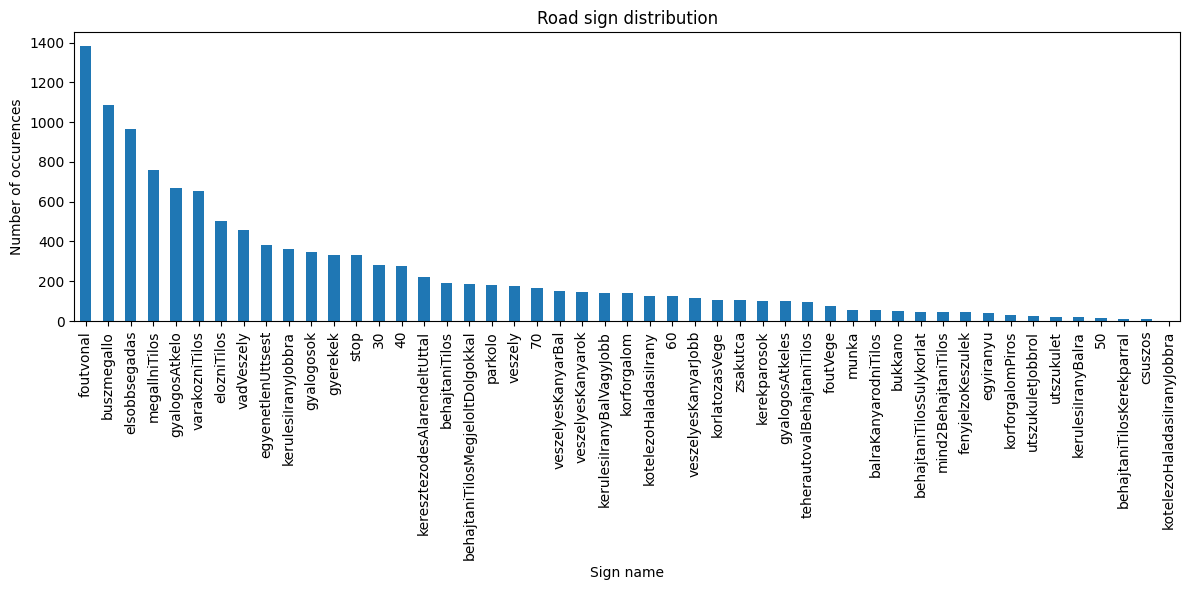

In [30]:
df = pd.read_csv(labels_csv_path)

label_counts = df.drop(columns=["filename"]).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Road sign distribution")
plt.xlabel("Sign name")
plt.ylabel("Number of occurences")
plt.tight_layout()
plt.show()


In [ ]:
labels_df = pd.read_csv(labels_csv_path)

In [12]:
filtered_df = pd.read_csv(filtered_path)

## Dataset construction

In [ ]:
# Loading dataset
image_paths = [str(multi_label_dir) + "/" + fname for fname in filtered_df["filename"]]
labels = filtered_df.drop(columns=["filename"]).values.astype("float32")

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = image / 255.0
    return image, label


In [16]:
image_paths[0]

'../MultiLabelFrames/0001_1.5_43.jpg'

In [14]:
# tf.data.Dataset construction
tf_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

tf_dataset = tf_dataset.map(
    load_image, num_parallel_calls=DATA_AUTOTUNE
)
tf_dataset = tf_dataset.shuffle(
    buffer_size=buffer_size, seed=SEED
)

In [ ]:
# Splitting Train/Val
total_size = len(image_paths)
train_size = int(total_size * 0.8)

train_ds = tf_dataset.take(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)
val_ds = tf_dataset.skip(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)

# Sign names 
sign_names =filtered_df.columns.drop("filename").tolist()

print(f"Dataset loaded. Number if images: {total_size}")

Dataset loaded. Number if images: 7904


In [16]:
(img_size, img_size, 3)

(256, 256, 3)

## Model construction

In [ ]:
# Model construction
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3), 
    include_top=False,
    alpha=1.3,
    # classes=num_classes,
    weights='imagenet',
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu',
                 kernel_initializer=dense_initializer,
                 kernel_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                 activity_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                 ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu',
                 kernel_initializer=dense_initializer,
                 kernel_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                 activity_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                 ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu',
                kernel_initializer=dense_initializer,
                kernel_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                activity_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001),
                ),
    layers.Dense(len(sign_names), activation='sigmoid')  # multi-label
])

In [35]:
base_model.summary()

Model: "mobilenetv2_1.30_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 40  160         ['Conv1[0][0]']                  
                                )                                              

## Training

In [ ]:
# TODO
# Class weights by TF (modified)

from sklearn.utils import class_weight

sk_class_weights = dict(enumerate(
    class_weight.compute_class_weight('balanced', 
                                      classes=class_names, 
                                      y=np.concatenate([train_labels, valid_labels])
                                      )
                                  )
                        )
sk_class_weights[1] /= 2
print("SK Weights:", sk_class_weights)

In [ ]:
# Compiling
model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=[
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [ ]:
# Callbacks

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        chekpoint_path,
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
        initial_value_threshold=0.92,
    ), 
    tf.keras.callbacks.TensorBoard(
        log_path,
        histogram_freq=0,
        write_steps_per_second=True,
        write_images=False,
        profile_batch='10, 15',
    ), 
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ProgbarLogger()
]

In [37]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, 
    # callbacks=callbacks, 
    shuffle=True,
    # class_weight=sk_class_weights,
    validation_freq=1,
    use_multiprocessing=True,
    verbose=2
)

Epoch 1/20
198/198 - 23s - loss: 0.2914 - AUC: 0.6293 - precision: 0.0445 - recall: 0.1696 - val_loss: 0.1380 - val_AUC: 0.7415 - val_precision: 0.4375 - val_recall: 0.0503 - 23s/epoch - 115ms/step
Epoch 2/20
198/198 - 19s - loss: 0.0943 - AUC: 0.8431 - precision: 0.5841 - recall: 0.1000 - val_loss: 0.0960 - val_AUC: 0.8415 - val_precision: 0.5864 - val_recall: 0.1368 - 19s/epoch - 96ms/step
Epoch 3/20
198/198 - 19s - loss: 0.0779 - AUC: 0.9080 - precision: 0.7169 - recall: 0.1790 - val_loss: 0.0902 - val_AUC: 0.8656 - val_precision: 0.5743 - val_recall: 0.2236 - 19s/epoch - 95ms/step
Epoch 4/20
198/198 - 19s - loss: 0.0664 - AUC: 0.9422 - precision: 0.7666 - recall: 0.2623 - val_loss: 0.0812 - val_AUC: 0.8891 - val_precision: 0.6439 - val_recall: 0.2891 - 19s/epoch - 95ms/step
Epoch 5/20
198/198 - 19s - loss: 0.0567 - AUC: 0.9630 - precision: 0.8111 - recall: 0.3526 - val_loss: 0.0785 - val_AUC: 0.8965 - val_precision: 0.6254 - val_recall: 0.3653 - 19s/epoch - 95ms/step
Epoch 6/20
198

## Model performance visualization

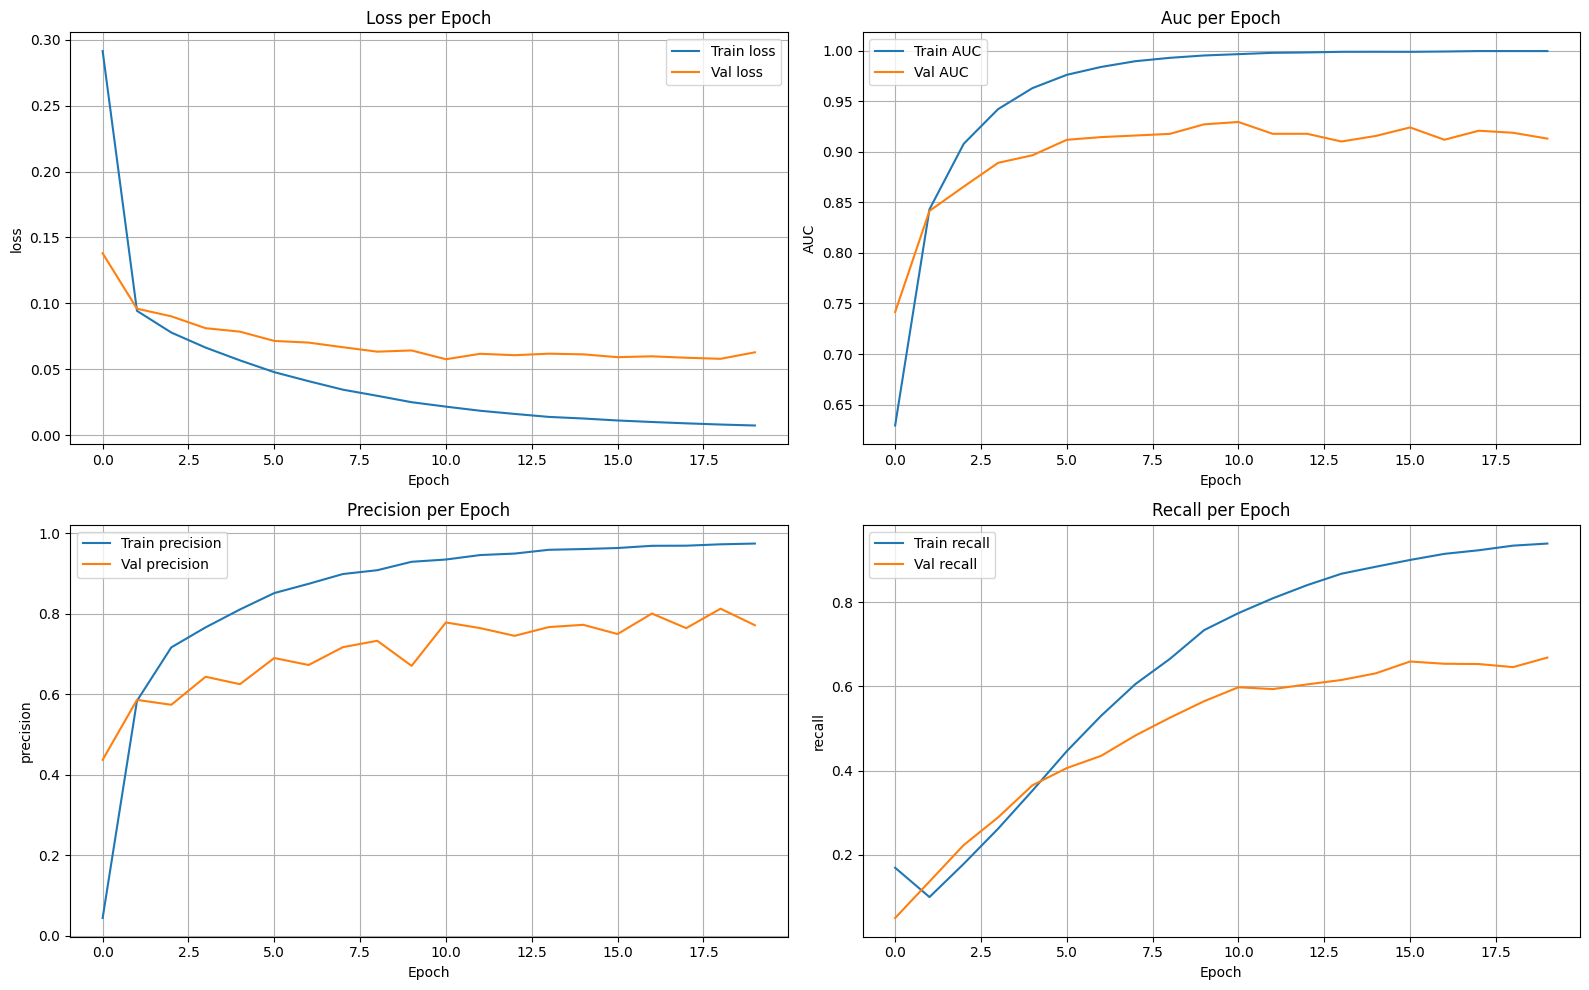

In [38]:
# Graphs
def plot_training_history(history):
    metrics = ['loss', 
               'AUC', 
               'precision',
               'recall'
            ]
    
    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric.capitalize()} per Epoch')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Save model as a keras file
model.save(f"../mentett_model/traffic_sign_model_{exp_name}.keras")

# Save model as a .h5 file
# model.save(f"../mentett_model/traffic_sign_model_{exp_name}.h5")

# Save model as a tf file
#model.save(f"../mentett_model/multilabel_model_{exp_name}.tf", save_format="tf")
#print("Modell elmentve SavedModel formátumban.")

In [35]:
MODEL_PATH = f"../mentett_model/traffic_sign_model_05_10_2025_18_46.keras"
model = load_model(MODEL_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.30_224 (Funct  (None, 8, 8, 1664)       3766048   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:

DATASET_PATH = Path("../MultiLabelFrames")
CSV_PATH = DATASET_PATH / "labels_filtered.csv"
MODEL_PATH = ("../mentett_model/traffic_sign_model_05_10_2025_18_46.keras")
IMG_SIZE = (256, 256)
THRESHOLD = 0.5
NUM_SAMPLES = 10

model = load_model(MODEL_PATH)
df = pd.read_csv(CSV_PATH)
sign_names = df.columns.drop("filename").tolist()

# Select randomly
samples = df.sample(NUM_SAMPLES, random_state=42)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.expand_dims(image / 255.0, axis=0)
    return image

# Predict and show
for _, row in samples.iterrows():
    image_path = str(DATASET_PATH / row["filename"])
    label_vector = row.drop("filename").values.astype("float32")
    true_labels = [sign for sign, val in zip(sign_names, label_vector) if val == 1]

    image = load_image(image_path)
    prediction = model.predict(image)[0]
    predicted_labels = [sign for sign, val in zip(sign_names, prediction) if val > THRESHOLD]

    print(f"{row['filename']}")
    print(f"Real labels      : {true_labels}")
    print(f"Model prediction : {predicted_labels}")
    print("-" * 60)


1/1 [==============================] - 1s 570ms/step
0117_25.5_766.jpg
Real labels      : ['parkolo']
Model prediction : ['parkolo']
------------------------------------------------------------
1/1 [==============================] - 0s 21ms/step
0013_0.0_-1.jpg
Real labels      : ['behajtaniTilosMegjeloltDolgokkal']
Model prediction : ['behajtaniTilosMegjeloltDolgokkal']
------------------------------------------------------------
1/1 [==============================] - 0s 20ms/step
0010_18.5_548.jpg
Real labels      : ['buszmegallo']
Model prediction : ['buszmegallo']
------------------------------------------------------------
1/1 [==============================] - 0s 22ms/step
0180_24.5_735.jpg
Real labels      : ['50']
Model prediction : ['50']
------------------------------------------------------------
1/1 [==============================] - 0s 21ms/step
0164_21.0_631.jpg
Real labels      : ['foutvonal', 'gyerekek']
Model prediction : ['foutvonal', 'gyerekek']
---------------------

1/1 [==============================] - 0s 28ms/step
                                  precision    recall  f1-score   support

                              30       1.00      0.92      0.96       249
                              50       1.00      1.00      1.00        18
                              60       1.00      0.83      0.91        87
                              70       0.91      1.00      0.95       154
                     elozniTilos       0.87      0.98      0.92       402
    keresztezodesAlarendeltUttal       0.93      0.84      0.88       192
                       foutvonal       0.91      1.00      0.95      1250
                   elsobbsegadas       0.96      0.89      0.92       744
                            stop       0.96      0.73      0.83       282
             mind2BehajtaniTilos       0.92      1.00      0.96        24
      teherautovalBehajtaniTilos       1.00      0.76      0.86        75
                  behajtaniTilos       0.81      0.94      

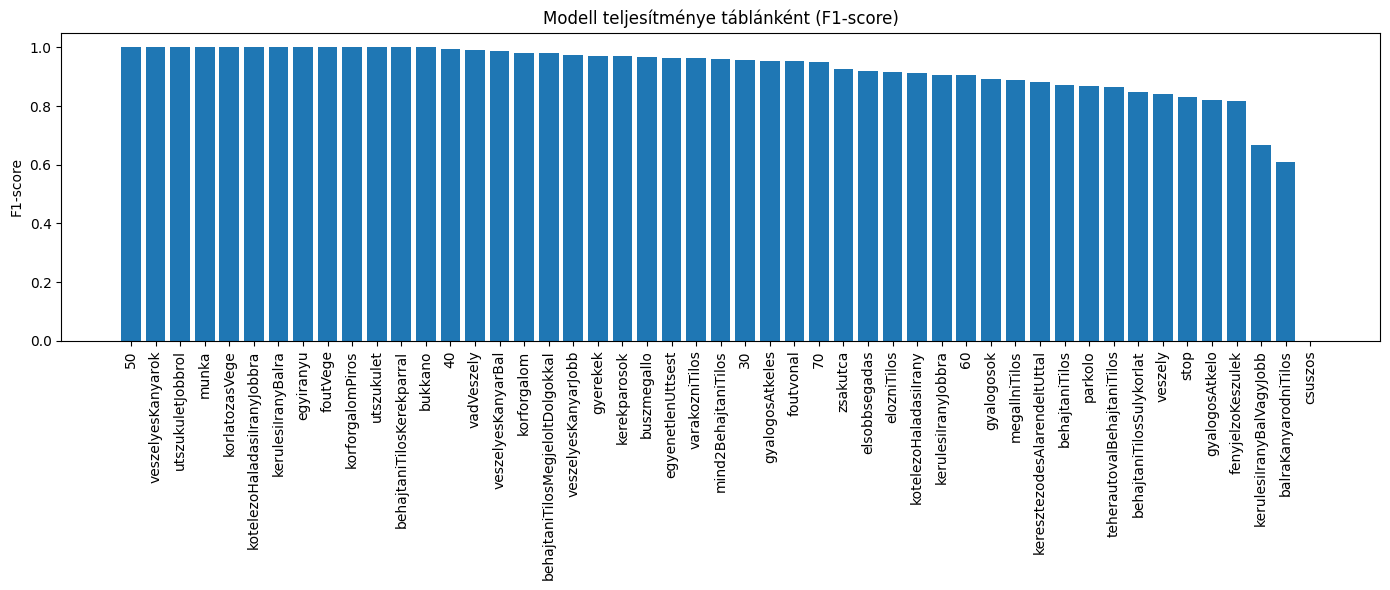

In [ ]:
DATASET_PATH = Path("../MultiLabelFrames")
CSV_PATH = DATASET_PATH / "labels_filtered.csv"
MODEL_PATH = r"D:\Szakdolgozat\githubclone\kozlekedesi_tabla_felismero\mentett_model\traffic_sign_model_05_10_2025_18_46.keras"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
THRESHOLD = 0.4

# Címkék betöltése
df = pd.read_csv(CSV_PATH)
sign_names = df.columns.drop("filename").tolist()
label_map = {name: i for i, name in enumerate(sign_names)}

# Dataset generáló
def gen():
    for _, row in df.iterrows():
        path = str(DATASET_PATH / row["filename"])
        label = row.drop("filename").values.astype("float32")
        yield path, label

# Előfeldolgozás
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# tf.data.Dataset létrehozása
ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(len(sign_names),), dtype=tf.float32)
    )
).map(preprocess).batch(BATCH_SIZE)

# Modell betöltése
model = load_model(MODEL_PATH)

# Előrejelzések
y_true = []
y_pred = []

for images, labels in ds:
    probs = model.predict(images)
    preds = (probs > THRESHOLD).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Jelentés kiírása
print(classification_report(np.array(y_true), np.array(y_pred), target_names=sign_names, zero_division=0))

report_dict = classification_report(
    np.array(y_true), np.array(y_pred),
    target_names=sign_names,
    zero_division=0,
    output_dict=True
)

# Kivesszük az F1-score-okat osztályonként
f1_scores = {label: metrics["f1-score"] for label, metrics in report_dict.items() if label in sign_names}

# Rendezés F1-score alapján
f1_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

# Ábra
plt.figure(figsize=(14, 6))
plt.bar(f1_sorted.keys(), f1_sorted.values())
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("Modell teljesítménye táblánként (F1-score)")
plt.tight_layout()
plt.show()


In [42]:
VIDEO_PATH = "../Videos/0004.mp4"
OUTPUT_CSV = "../Detections/0004.csv"
MODEL_PATH = "../mentett_model/traffic_sign_model_05_10_2025_18_46.keras"
IMG_SIZE = (256, 256)
THRESHOLD = 0.7
TIMESTEP = 0.5


model = load_model(MODEL_PATH)

label_path = Path("../MultiLabelFrames/labels.csv")
df_labels = pd.read_csv(label_path)
sign_names = df_labels.columns.drop("filename").tolist()

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

timestamps = np.arange(0, duration, TIMESTEP)
results = []

for t in timestamps:
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if not ret:
        results.append([t] + [0] * len(sign_names))
        continue

    frame = cv2.resize(frame, IMG_SIZE)
    image = tf.convert_to_tensor(frame / 255.0, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    labels = (preds > THRESHOLD).astype(int).tolist()

    results.append([t] + labels)

cap.release()

df_out = pd.DataFrame(results, columns=["timestamp"] + sign_names)
Path(OUTPUT_CSV).parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(OUTPUT_CSV, index=False)
print("Done:", OUTPUT_CSV)


1/1 [==============================] - 0s 20ms/step
Done: ../Detections/0004.csv


In [43]:

VIDEO_PATH = "../Videos/0004.mp4"
CSV_PATH = "../Detections/0004.csv"
IMG_SIZE = (960, 540)

df = pd.read_csv(CSV_PATH)
columns = df.columns.tolist()
timestamp_col = columns[0]
label_cols = columns[1:]

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# User Interface
class PredictionViewer:
    def __init__(self, root):
        self.root = root
        self.root.title("Model prediction")

        self.canvas = tk.Canvas(root, width=IMG_SIZE[0], height=IMG_SIZE[1])
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.info_label = tk.Label(root, text="", font=("Arial", 12), justify="left")
        self.info_label.grid(row=1, column=0, columnspan=3, pady=10)

        self.back_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.back_btn.grid(row=2, column=0)

        self.forward_btn = tk.Button(root, text="Next >>", command=self.next_frame)
        self.forward_btn.grid(row=2, column=2)

        self.frame_index = 0
        self.update_frame()

    def update_frame(self):
        row = df.iloc[self.frame_index]
        timestamp = row[timestamp_col]
        cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = cap.read()
        if not ret:
            return
        frame = cv2.resize(frame, IMG_SIZE)
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        detected = [name for name in label_cols if row[name] == 1]
        text = f"Idő: {timestamp:.1f} s\nFelismert táblák: {', '.join(detected) if detected else 'nincs'}"
        self.info_label.config(text=text)

    def next_frame(self):
        if self.frame_index + 1 < len(df):
            self.frame_index += 1
            self.update_frame()

    def prev_frame(self):
        if self.frame_index > 0:
            self.frame_index -= 1
            self.update_frame()



In [44]:
# Start
if __name__ == "__main__":
    root = tk.Tk()
    app = PredictionViewer(root)
    root.mainloop()

In [29]:
for image_batch, labels in train_ds:
    for image in image_batch:
        print(image)
        break

tf.Tensor(
[[[0.57843137 0.6843137  0.80196077]
  [0.5764706  0.68235296 0.8       ]
  [0.57843137 0.6843137  0.80196077]
  ...
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]]

 [[0.57843137 0.6843137  0.80196077]
  [0.5764706  0.68235296 0.8       ]
  [0.57843137 0.6843137  0.80196077]
  ...
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]]

 [[0.57843137 0.6843137  0.80196077]
  [0.5764706  0.68235296 0.8       ]
  [0.57843137 0.6843137  0.80196077]
  ...
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]
  [0.5686275  0.6745098  0.7882353 ]]

 ...

 [[0.53137255 0.5470588  0.4882353 ]
  [0.5372549  0.5529412  0.49411765]
  [0.46372548 0.47941175 0.42058823]
  ...
  [0.12352941 0.18235295 0.1627451 ]
  [0.1264706  0.18529412 0.17156863]
  [0.1264706  0.18333334 0.17745098]]

 [[0.52843136 0.5441176  0.4852941 ]
  [0.4617647  0.47745097 0